In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"

### Loading in data and pretrained model

In [2]:
timm.list_models("vit*",pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch14_reg4_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.dfn2b',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base

### Recursively get every image

In [3]:
def image_fetch(src,image_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".jpg" in l[i] or ".jpeg" in l[i] or ".png" in l[i]):
                image_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    image_fetch(str(src+l[i]+"/"),image_paths)
                except:
                    continue
                            
def class_fetch(image_paths)->(list,dict):
    s=set()
    for i in image_paths:
        s.add(i.split("/")[-2])
    d={}
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d

In [4]:
class modified_dataset_loader(Dataset):
    
    def __init__(self,targ_dir=None,paths=None,transformations=None):

        if(targ_dir!=None):
            self.transform=transformations
            self.paths=[]
            image_fetch(targ_dir,self.paths)
            self.classes, self.class_to_idx=class_fetch(self.paths)
        else:
            self.transform=transformations
            self.paths=paths
            self.classes, self.class_to_idx=class_fetch(self.paths)
            


    def load_image(self,index)-> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        image=self.load_image(index)
        class_val=self.class_to_idx[(self.paths[index]).split("/")[-2]]
        if(self.transform):
            image=self.transform(image)
        return image,class_val

In [5]:
batch_size=32
cpu_count=multiprocessing.cpu_count()
model_name="vit_base_patch16_384.orig_in21k_ft_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Resize(size=(384,384))])

#train_data=torchvision.datasets.ImageFolder("./data/train",transform=transforms)
#test_data=torchvision.datasets.ImageFolder("./data/test",transform=transforms)
#train_data=modified_dataset_loader("../sample_model/pizza_steak/",transformations=transform_data)

data_path=[]
image_fetch("../../../Research/RSNA_Dataset/Dataset/test2/",data_path)

train,test=train_test_split(data_path,test_size=0.2)
test,val=train_test_split(test,test_size=0.5)

train_data=modified_dataset_loader(paths=train,transformations=transform_data)
test_data=modified_dataset_loader(paths=test,transformations=transform_data)
val_data=modified_dataset_loader(paths=val,transformations=transform_data)

print(f"No. of images in Training set: {len(train)}\nNo. of images in Validation set: {len(val)}\nNo. of images in Test set: {len(test)}")

No. of images in Training set: 21347
No. of images in Validation set: 2669
No. of images in Test set: 2668


In [6]:
train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
val_loader=torch.utils.data.DataLoader(val_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

##### Freezing layers

In [7]:
count=0
for param in model.parameters(): #152 layers
    if(count>=100):
        break
    param.requires_grad=False
    count+=1

##### Model Modification

In [8]:
#Changing the classification part
model.head=nn.Linear(in_features=model.head.in_features,out_features=2)

class modified_vit(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
        self.sequential=nn.Sequential(nn.Linear(in_features=1024,out_features=2048),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=256),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=256),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=2))
    def forward(self,x):
        return self.sequential(self.model(x))

In [9]:
#model=modified_vit(model)
model=model.to(device)

In [10]:
summary(model)

Layer (type:depth-idx)                   Param #
VisionTransformer                        443,904
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       (590,592)
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               (1,536)
│    │    └─Attention: 3-2               (2,362,368)
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               (1,536)
│    │    └─Mlp: 3-6                     (4,722,432)
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               (1,536)
│    │    └─Attention: 3-10              (2,362,368)
│    │    └─Ident

In [11]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### Visualizing Transformed Data

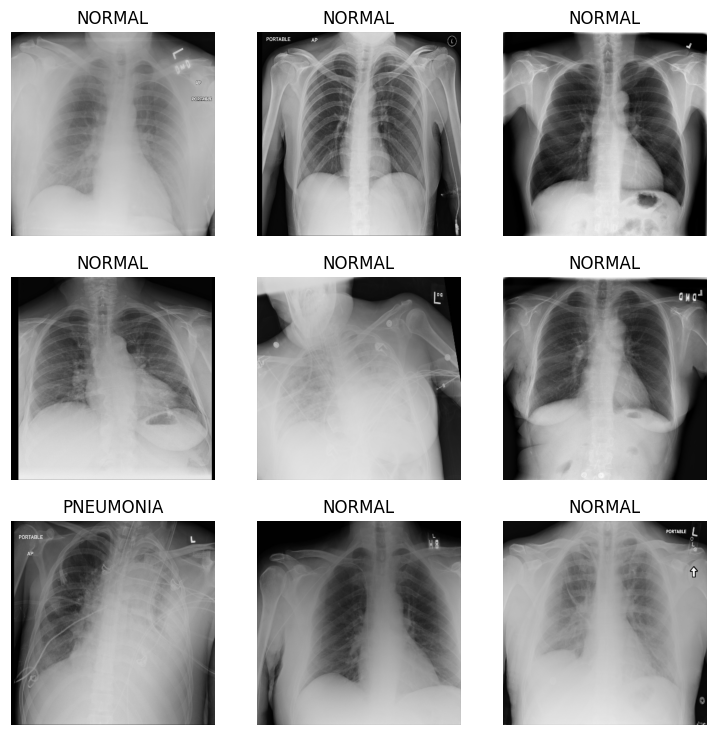

In [12]:
plt.figure(figsize=(9,9))
plt.axis(False)
for i in range(1,10):
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    data=next(iter(train_loader))
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(train_data.classes[label.item()])
    plt.axis(False)
    plt.imshow(image)
    

### Optimizer and Loss and Logdir

In [13]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [14]:
#log_dir = "./"+model_name+"feature_extractor_tensorboard"
#writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing model

In [15]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[-0.0598, -0.3157],
        [-0.3018, -0.2014],
        [-0.1936, -0.0412],
        [-0.2812, -0.2109],
        [-0.0225, -0.0130],
        [-0.1045, -0.2407],
        [ 0.0701,  0.1548],
        [-0.2066, -0.0815],
        [-0.0922, -0.1022],
        [-0.0442, -0.1419],
        [-0.2413, -0.1633],
        [-0.1493, -0.1472],
        [-0.1401, -0.1376],
        [-0.1790, -0.0317],
        [ 0.0035, -0.2608],
        [-0.4334, -0.2727],
        [-0.1809, -0.3563],
        [-0.1207, -0.2846],
        [-0.2540, -0.1801],
        [-0.2106, -0.1518],
        [-0.1049, -0.1794],
        [-0.4471, -0.0585],
        [-0.2537, -0.2439],
        [-0.1799, -0.1856],
        [-0.1976, -0.1035],
        [-0.2679, -0.2861],
        [-0.2971, -0.1624],
        [-0.2310, -0.1848],
        [ 0.0049,  0.0700],
        [ 0.2674, -0.0336],
        [-0.2140, -0.1809],
        [-0.2316, -0.1926]], device='cuda:0')
tensor(0.7099, device='cuda:0')
0.375


### Training Loop

In [ ]:
epochs=10

train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and val data
    temp_train_accuracy=[]
    temp_val_accuracy=[]
    temp_train_loss=[]
    temp_val_loss=[]

    net_train_accuracy=0
    net_val_accuracy=0
    net_train_loss=0
    net_val_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    #writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing on validation data:")
    model.eval()

    with tqdm(total=len(val_loader)) as pbar2:
        for x,y in val_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_val_accuracy.append(accuracy_test)
                temp_val_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
    net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
    val_accuracy.append(net_val_accuracy)
    val_loss.append(net_val_loss)
    #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
    #writer.add_scalar("Val Loss",net_val_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Val Accuracy: {net_val_accuracy}  Val Loss: {net_val_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/668 [00:00<?, ?it/s]